#### 🔎 5.1.1 선형회귀(단층 퍼셉트론)

- `unsqueeze()` : 차원을 하나 늘려줄 때

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x + torch.randn(5, 1)

- `nn.Module`을 상속받는 클래스 `LinearRegressor` 만들기
- `__init__`, `super().__init__()` : 초기 세팅에 필요한 내용 입력
- `nn.Linear(N, M, bias=True)`
    - N : 입력 변수의 개수(x의 크기 1)
    - M : 출력 변수의 개수(y의 크기1)
- `forward` : 실제 입력값이 들어와 연산이 진행하는 순서와 방법을 정하는 곳

In [3]:
class LinearRegressor(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.fc = nn.Linear(1, 1, bias=True)
        
    def forward(self, x) :
        y = self.fc(x)
        
        return y

- 클래스가 완성 됐으면 `model` 선언
- 손실함수 : MSE
- 최적화 방법에 모델 파라미터를 넣어 줄 때는 `model.parameters()` 입력

In [4]:
model = LinearRegressor()
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
loss_stack = [] # loss값 저장할 공간
for epoch in range(1001) :
    optimizer.zero_grad() # 옵티마이저 0으로 초기화
    y_hat = model(x) # x값으로 모델 예측
    loss = criterion(y_hat, y) # 손실값 계산
    loss.backward() # 역전파 계산
    optimizer.step() # 최적화(업데이트)
    loss_stack.append(loss.item()) # loss값 저장
    if epoch % 100 == 0 :
        print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:6.793081760406494
Epoch 100:0.6982947587966919
Epoch 200:0.2869405150413513
Epoch 300:0.25816071033477783
Epoch 400:0.25524789094924927
Epoch 500:0.25418558716773987
Epoch 600:0.2533453404903412
Epoch 700:0.2526065707206726
Epoch 800:0.2519514262676239
Epoch 900:0.25137001276016235
Epoch 1000:0.25085389614105225


In [6]:
# 예측할 때는 gradient 계산 필요 없으므로
with torch.no_grad() :
    y_hat = model(x)

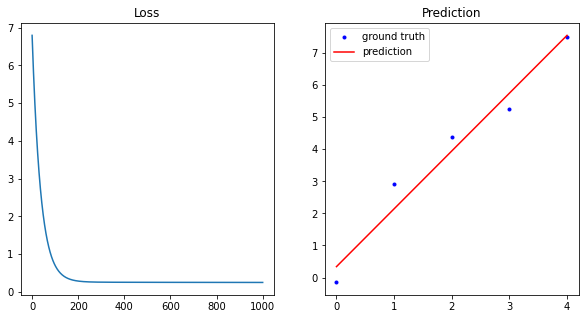

In [7]:
# 그래프 그리기
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")

plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

---------------------------------------------------------------------------------------------------

#### 🔎 5.1.2 집값 예측하기

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

##### 💡 데이터 세트 만들기

- 스케일링 된 집값 데이터를 read_csv를 통해 불러온다.
    - 변수의 개수 : 13개
    - 인스턴스 개수 : 506개
- `index_col=[0]` 
    - csv 파일의 첫번째 열에 있는 데이터 인덱스를 배제하고 데이터 프레임 만들기

In [14]:
df = pd.read_csv('C:/nozzi/Pytorch/딥러닝을 위한 파이토치 입문/CH5. 인공 신경망/data/reg.csv', index_col=[0])
df

x1        x2        x3        x4        x5        x6        x7  \
0    0.034633  0.206919  0.137057  0.540526  0.193941  0.699239  0.630532   
1    0.028920  0.014315  0.276113  0.255945  0.618886  0.555407  0.782263   
2    0.020627  0.033230  0.281116  0.525591  0.165269  0.624102  0.586005   
3    0.022749  0.033801  0.125044  0.263253  0.251509  0.658532  0.432160   
4    0.022148  0.029374  0.121057  0.521126  0.399670  0.448086  0.520158   
..        ...       ...       ...       ...       ...       ...       ...   
501  0.028702  0.019528  0.455716  0.097575  0.576859  0.588769  0.654701   
502  0.034217  0.009498  0.490485  0.372934  0.532351  0.580505  0.750547   
503  0.035352  0.021495  0.423918  0.397988  0.349407  0.610529  0.907637   
504  0.026182  0.028603  0.443442  0.509663  0.229142  0.667841  0.867135   
505  0.045519  0.029289  0.446156  0.499371  0.239768  0.379320  0.775146   

           x8        x9       x10       x11       x12       x13     Price  
0    0.239410  0.027375  0.209857  0.347609  0.996394  0.102644  0.422222  
1    0.482977  0.103031  0.106690  0.520776  0.996650  0.187120  0.368889  
2    0.272713  0.036010  0.106986  0.595301  0.983284  0.084079  0.660000  
3    0.344932  0.150018  0.068317  0.651297  0.989989  0.015990  0.631111  
4    0.495342  0.104383  0.069360  0.560116  0.998723  0.092782  0.693333  
..        ...       ...       ...       ...       ...       ...       ...  
501  0.188444  0.007595  0.165409  0.736795  0.982923  0.219891  0.386667  
502  0.143776  0.051186  0.166428  0.867950  0.995114  0.207453  0.346667  
503  0.087385  0.083448  0.164870  0.782704  0.995791  0.094044  0.420000  
504  0.236241  0.016177  0.167554  0.749186  0.986855  0.107399  0.377778  
505  0.157582  0.084328  0.166314  0.835237  0.994221  0.146302  0.153333  

[506 rows x 14 columns]

##### 💡 데이터 프레임을 넘파이 배열로 만들기

- `drop` : 삭제
    - Price를 axis=1(열)을 기준으로 삭제
- X, Y 둘 다 numpy로 변환

In [77]:
X = df.drop('Price', axis = 1).to_numpy()
Y = df["Price"].to_numpy().reshape((-1, 1))

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

##### 💡 텐서 데이터 만들기

- trainloader, testloader 만들기

In [79]:
class TensorData(Dataset) :
    def __init__(self, x_data, y_data) :
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
        
    def __getitem__(self, index) :
        return self.x_data[index], self.y_data[index]
    
    def __len__(self) :
        return self.len
    
trainsets = TensorData(X_train, Y_train)
testsets = TensorData(X_test, Y_test)

trainloader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle=False)

##### 💡 모델 구축하기

- `Regressor` 
    - 입력층 : 1개
    - 은닉층 : 2개
    - 출력층 : 1개
- Data feature의 개수가 13개 이므로 입력층의 노드 : 13개(x변수의 개수)
- 하나의 값으로 표현된 집값을 예측하는 것이므로 출력층은의 노드 : 1개
- 은닉층은 사용자의 선택으로 정할 수 있다. 
    - 본 모델에서는 각 은닉층마다 50, 30개의 노드를 갖도록 구축
    - 기본적으로 **이전 층의 출력값과 다음 층의 입력값의 크기는 같아**야 한다.

- 나머지 Linear 모델에 관한 내용은 티스토리 참고

In [80]:
class Regressor(nn.Module) :
    def __init__(self) : 
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias = True)
        self.fc2 = nn.Linear(50, 30, bias = True)
        self.fc3 = nn.Linear(30, 1, bias = True)
        # 연산이 될 때마다 50%의 비율로 랜덤하게 노드를 없앤다. (forward 함수에서 적용 위치를 정해준다.)
        self.dropout = nn.Dropout(0.5)
        
        
    def forward(self, x) :
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x

##### 💡 모델 학습하기

- `weight_decay` : L2 정규화에서의 penalty 값 (값이 클수록 제약조건이 강함 - 가중치가 작아짐 - 오버피팅 방지)

In [81]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-7)

In [82]:
loss_ = []
n = len(trainloader) # 학습 데이터 수 253개(32개*7개 + 29개*1개 = 8)
for epoch in range(400) :
    
    # 매 에폭 손실 함수값의 평균을 구하기 위해 초깃값을 0으로 
    running_loss = 0.0
    
    # 배치를 불러와 학습
    for data in trainloader :
        inputs, values = data
        # gradient 초기화
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_.append(running_loss/n)

##### 💡 손실 함수값 그리기

- 학습 데이터의 손실 함수값으로는 모델의 성능을 판단할 수 없지만, 학습이 잘 진행되었는지 파악할 수 있다.
- 손실 함수값이 감소하는 것을 학습이 잘 진행되었다는 의미
- 과적합 현상이 나타났는지 평가 결과가 어떤지에 따라 모델을 **튜닝**하거나 **학습 전략**을 다르게 설정해야 한다.

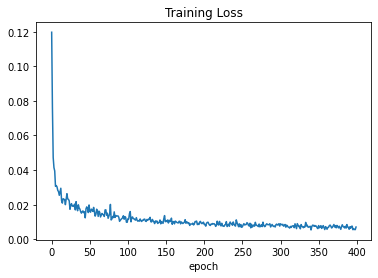

In [83]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

##### ✨✨모델 평가하기

- 최종 모델 평가 : RMSE 사용

In [96]:
# evaluation 함수에 dataloader 받는다.
def evaluation(dataloader) :
    
    # 예측값과 실제값을 저장하기 위해 빈 텐서 만든다. 
    # 값들을 모두 저장하지 않고 for문에서 누적 방식으로도 계산할 수 있지만 예시를 통해 torch.cat 공부 !
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype = torch.float) # 실제값을 저장하는 텐서
    
    # requires_grad 비활성화
    with torch.no_grad() :
        # 드롭아웃과 같은 정규화 기법은 학습시에만 적용해야 하므로
        # 모델 내에서 학습 시에만 동작하는 장치들을 비활성화
        model.eval()
        for data in dataloader :
            inputs, values = data
            outputs = model(inputs)
            # 0번째 차원을 기준으로 누적한다는 의미
            # (예를 들어) 10x2, 10x2인 두 텐서가 있을 때, cat 기준이 0이면 20x2, 1이면 10x4
            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)
            
            
    # 텐서 데이터를 넘파이 배열로 변경        
    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    
    return rmse

In [97]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  0.060758144
Test RMSE:  0.11639263


- 결과를 보면 학습 결과와 테스트 결과 차이가 크다.
- 따라서 학습 데이터에 과적합이 되어 있다고 판단하지만, 데이터를 무작위로 나누고 모델의 초깃값도 random initial parameter를 사용했기 때문에 학습을 할 때마다 다를 수도 있다.
- 따라서 교차 검증이나 여러 번의 실험을 통해 결과의 경향성 확인해야 한다.